In [1]:
import cv2
import os
from matplotlib import pyplot
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,roc_auc_score
import numpy as np
import pandas as pd

In [2]:
def build_network(input_shape):
    '''
    Define the neural network to learn image similarity
    Input : 
            input_shape : shape of input images
            embeddingsize : vectorsize used to encode our picture   
    '''
     # Convolutional Neural Network
    network = Sequential([
        # layer 1
        Conv2D(64, (7,7), strides=(2, 2), activation='relu', input_shape=input_shape, kernel_initializer='he_uniform'),
        MaxPool2D(pool_size = (3, 3), strides = (2, 2)),
        # layer 2
        Conv2D(64, (1,1), strides=(1, 1), activation='relu', kernel_initializer='he_uniform'),
        Conv2D(192, (3,3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform'),
        MaxPool2D(pool_size = (3, 3), strides = (2, 2)),
        # layer 3
        Conv2D(192, (1,1), strides=(1, 1), activation='relu', kernel_initializer='he_uniform'),
        Conv2D(192, (3,3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform'),
        MaxPool2D(pool_size = (3, 3), strides = (2, 2)),
        # layer 4
        Conv2D(384, (1,1), strides=(1, 1), activation='relu', kernel_initializer='he_uniform'),
        Conv2D(384, (3,3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform'),
        # layer 5
        Conv2D(256, (1,1), strides=(1, 1), activation='relu', kernel_initializer='he_uniform'),
        Conv2D(256, (3,3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform'),
        # layer 6
        Conv2D(256, (1,1), strides=(1, 1), activation='relu', kernel_initializer='he_uniform'),
        Conv2D(256, (3,3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform'),
        MaxPool2D(pool_size = (3, 3), strides = (2, 2)),
        Flatten(),
        # fully connected layers
        Dense(256, activation='relu', kernel_initializer='he_uniform'),
        Dense(128, activation='relu', kernel_initializer='he_uniform'),
        # L2 normalization
        Lambda(lambda x: K.l2_normalize(x,axis=-1))        
    ])
#     network.add(Convolution2D(128, (7,7), activation='relu',
#                      input_shape=input_shape,
#                      kernel_initializer='he_uniform'))
#     network.add(MaxPooling2D())
#     network.add(Convolution2D(128, (3,3), activation='relu', kernel_initializer='he_uniform'))
#     network.add(MaxPooling2D())
#     network.add(Convolution2D(256, (3,3), activation='relu', kernel_initializer='he_uniform'))
#     network.add(Flatten())
#     network.add(Dense(4096, activation='relu',
#                    kernel_initializer='he_uniform'))
    
    
#     network.add(Dense(embeddingsize, activation=None,
#                    kernel_initializer='he_uniform'))
    
#     #Force the encoding to live on the d-dimentional hypershpere
#     network.add(Lambda(lambda x: K.l2_normalize(x,axis=-1)))
    
    return network

In [3]:
network = build_network((220, 220, 3))
network.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 107, 107, 64)      9472      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 53, 53, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 53, 53, 64)        4160      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 51, 51, 192)       110784    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 192)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 192)       37056     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 23, 23, 192)       3

In [4]:
def get_batch_random(batch_size):
    #get the new size
    dim1 = 220
    dim2 = 220
    
    #initialize the numpy array with the shape of [total_sample, no_of_pairs, dim1, dim2, dim3(no_of_color_channels)]
    x = np.zeros([3, batch_size, dim1, dim2, 3]) 
    
    for i in range(batch_size):
        ind1 = 0
        ind2 = 0
        ind3 = 0
        
        #get random person number
        person = np.random.randint(40)
        #read images from same directory (genuine pair)
        while ind1 == ind2:
            ind1 = np.random.randint(10)
            ind2 = np.random.randint(10)
            ind3 = np.random.randint(10)
        while True:
            neg = np.random.randint(40)
            if person != neg:
                break
        # read the three images
        img1 = cv2.imread('./person/person_'+str(person+1)+'/'+str(ind1)+'.jpg')
        img2 = cv2.imread('./person/person_'+str(person+1)+'/'+str(ind2)+'.jpg')
        img3 = cv2.imread('./person/person_'+str(neg+1)+'/'+str(ind3)+'.jpg')
        
        #reduce the size
        img1 = cv2.resize(img1, (dim1,dim2), interpolation = cv2.INTER_AREA)
        img2 = cv2.resize(img2, (dim1,dim2), interpolation = cv2.INTER_AREA)
        img3 = cv2.resize(img3, (dim1,dim2), interpolation = cv2.INTER_AREA)
        
        #store the images to the initialized numpy array
        x[0, i, :, :, :] = img1
        x[1, i, :, :, :] = img2
        x[2, i, :, :, :] = img3

    return x

In [5]:
def get_batch_hard(draw_batch_size,hard_batchs_size,norm_batchs_size,network):
    """
    Create batch of APN "hard" triplets
    
    Arguments:
    draw_batch_size -- integer : number of initial randomly taken samples   
    hard_batchs_size -- interger : select the number of hardest samples to keep
    norm_batchs_size -- interger : number of random samples to add
    Returns:
    triplets -- list containing 3 tensors A,P,N of shape (hard_batchs_size+norm_batchs_size,w,h,c)
    """
    
    
    #Step 1 : pick a random batch to study
    studybatch = get_batch_random(draw_batch_size)
    
    #Step 2 : compute the loss with current network : d(A,P)-d(A,N). The alpha parameter here is omited here since we want only to order them
    studybatchloss = np.zeros((draw_batch_size))
    
    #Compute embeddings for anchors, positive and negatives
    A = network.predict(studybatch[0])
    P = network.predict(studybatch[1])
    N = network.predict(studybatch[2])
    
    #Compute d(A,P)-d(A,N)
    studybatchloss = np.sum(np.square(A-P),axis=1) - np.sum(np.square(A-N),axis=1)
    
    #Sort by distance (high distance first) and take the 
    selection = np.argsort(studybatchloss)[::-1][:hard_batchs_size]
    
    #Draw other random samples from the batch
    selection2 = np.random.choice(np.delete(np.arange(draw_batch_size),selection),norm_batchs_size,replace=False)
    
    selection = np.append(selection,selection2)
    
    triplets = [studybatch[0][selection,:,:,:], studybatch[1][selection,:,:,:], studybatch[2][selection,:,:,:]]
    
    return triplets

In [6]:
triplets = get_batch_hard(400,32,32,network)
triplets

[array([[[[ 15.,  13.,  13.],
          [ 14.,  12.,  12.],
          [ 14.,  12.,  12.],
          ...,
          [ 76.,  95., 103.],
          [ 75.,  94., 102.],
          [ 75.,  94., 102.]],
 
         [[ 15.,  13.,  13.],
          [ 14.,  12.,  12.],
          [ 14.,  12.,  12.],
          ...,
          [ 76.,  95., 103.],
          [ 75.,  94., 102.],
          [ 75.,  94., 102.]],
 
         [[ 15.,  13.,  13.],
          [ 14.,  12.,  12.],
          [ 14.,  12.,  12.],
          ...,
          [ 76.,  95., 103.],
          [ 75.,  94., 102.],
          [ 75.,  94., 102.]],
 
         ...,
 
         [[ 47.,  56.,  66.],
          [ 45.,  55.,  65.],
          [ 44.,  53.,  63.],
          ...,
          [ 79.,  96., 106.],
          [ 78.,  95., 105.],
          [ 80.,  96., 107.]],
 
         [[ 45.,  56.,  66.],
          [ 41.,  51.,  61.],
          [ 36.,  46.,  56.],
          ...,
          [ 78.,  94., 106.],
          [ 79.,  95., 107.],
          [ 82.,  98., 110.

In [7]:
# class TripletLossLayer(Layer):
#     def __init__(self, **kwargs):
#         super(TripletLossLayer, self).__init__(**kwargs)
    
#     def triplet_loss(self, inputs):
#         anchor, positive, negative = inputs
#         p_dist = K.sum(K.square(anchor-positive), axis=-1)
#         n_dist = K.sum(K.square(anchor-negative), axis=-1)
#         return K.sum(K.maximum(p_dist - n_dist + 0.2, 0), axis=0)
    
#     def call(self, inputs):
#         loss = self.triplet_loss(inputs)
#         self.add_loss(loss)
#         return loss

In [6]:
def triplet_loss(y_true, y_pred):
    anchor_out = y_pred[:, 0:128]
    positive_out = y_pred[:, 128:256]
    negative_out = y_pred[:, 256:384]
    
    pos_dist = K.sum(K.abs(anchor_out - positive_out), axis=1)
    neg_dist = K.sum(K.abs(anchor_out - negative_out), axis=1)
    
    probs = K.softmax([pos_dist, neg_dist], axis=0)
    
    return K.mean(K.abs(probs[0]) + K.abs(1.0 - probs[1]))

In [7]:
def build_model(input_shape, network, margin=0.2):
    '''
    Define the Keras Model for training 
        Input : 
            input_shape : shape of input images
            network : Neural network to train outputing embeddings
            margin : minimal distance between Anchor-Positive and Anchor-Negative for the lossfunction (alpha)
    
    '''
     # Define the tensors for the three input images
    anchor_input = Input(input_shape, name="anchor_input")
    positive_input = Input(input_shape, name="positive_input")
    negative_input = Input(input_shape, name="negative_input") 
    
    # Generate the encodings (feature vectors) for the three images
    encoded_a = network(anchor_input)
    encoded_p = network(positive_input)
    encoded_n = network(negative_input)
    
    #TripletLoss Layer
    #loss_layer = TripletLossLayer(name='triplet_loss_layer')([encoded_a,encoded_p,encoded_n])
    out = Concatenate()([encoded_a,encoded_p,encoded_n])
    # Connect the inputs with the outputs
    network_train = Model(inputs=[anchor_input,positive_input,negative_input],outputs=out)
    
    # return the model
    return network_train

In [8]:
model = build_model((220,220,3),network)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       [(None, 220, 220, 3) 0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     [(None, 220, 220, 3) 0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     [(None, 220, 220, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          3534848     anchor_input[0][0]               
                                                                 positive_input[0][0]  

In [9]:
def data_generator(n_iter, batch_size = 32):
    for i in range(1, n_iter+1):
        triplets = get_batch_hard(200,16,16,build_network((220,220,3)))
        yield ([triplets[0], triplets[1], triplets[2]], np.zeros((batch_size, 1)).astype("float32"))

In [10]:
model.compile(loss=triplet_loss, optimizer="adam")

In [13]:
model.fit(data_generator(4000), steps_per_epoch=150, epochs=25, verbose = 1)

Epoch 1/25
150/150 [==============================] - 1456s 10s/step - loss: 0.9725
Epoch 2/25
150/150 [==============================] - 1512s 10s/step - loss: 0.6959
Epoch 3/25
150/150 [==============================] - 1537s 10s/step - loss: 0.6057
Epoch 4/25
150/150 [==============================] - 1537s 10s/step - loss: 0.5527
Epoch 5/25
150/150 [==============================] - 1729s 12s/step - loss: 0.5556
Epoch 6/25
150/150 [==============================] - 1764s 12s/step - loss: 0.4754
Epoch 7/25
150/150 [==============================] - 1681s 11s/step - loss: 0.4161
Epoch 8/25
150/150 [==============================] - 1596s 11s/step - loss: 0.4144
Epoch 9/25
150/150 [==============================] - 1717s 11s/step - loss: 0.3521
Epoch 10/25
150/150 [==============================] - 1816s 12s/step - loss: 0.3320
Epoch 11/25
150/150 [==============================] - 1547s 10s/step - loss: 0.2701
Epoch 12/25
150/150 [==============================] - 1472s 10s/step - lo

In [14]:
model.save("Triplet_model.h5")

In [15]:
network.save("base_network.h5")

In [9]:
loaded_model = load_model("./base_network.h5")

In [12]:
# read data and store it in a numpy array as X and Y

def train_dataset():
    X = np.zeros((400,220,220,3))
    Y = np.zeros((400))
    count = 0
    i = 0
    for person in os.listdir('./person'):
        
        for img in os.listdir('./person/'+str(person)+'/'):
            j = 0
            image = cv2.imread('./person/'+str(person)+'/'+str(img))
            X[count,:,:,:] = cv2.resize(image, (220,220), interpolation = cv2.INTER_AREA)
            Y[count] = i
            count += 1
        i += 1
    return X, Y




# end it here

In [13]:
def compute_dist(a,b):
    return np.sum(np.square(a-b))
def compute_probs(network,X,Y):
    '''
    Input
        network : current NN to compute embeddings
        X : tensor of shape (m,w,h,3) containing pics to evaluate
        Y : tensor of shape (m,) containing true class
        
    Returns
        probs : array of shape (m,m) containing distances
    
    '''
    m = X.shape[0]
    nbevaluation = int(m*(m-1)/2)
    probs = np.zeros((nbevaluation))
    y = np.zeros((nbevaluation))
    
    #Compute all embeddings for all pics with current network
    embeddings = network.predict(X)
    
    size_embedding = embeddings.shape[1]
    
    #For each pics of our dataset
    k = 0
    for i in range(m):
            #Against all other images
            for j in range(i+1,m):
                #compute the probability of being the right decision : it should be 1 for right class, 0 for all other classes
                probs[k] = -compute_dist(embeddings[i,:],embeddings[j,:])
                if (Y[i]==Y[j]):
                    y[k] = 1
                    #print("{3}:{0} vs {1} : {2}\tSAME".format(i,j,probs[k],k))
                else:
                    y[k] = 0
                    #print("{3}:{0} vs {1} : \t\t\t{2}\tDIFF".format(i,j,probs[k],k))
                k += 1
    return probs,y
#probs,yprobs = compute_probs(network,x_test_origin[:10,:,:,:],y_test_origin[:10])

def compute_metrics(probs,yprobs):
    '''
    Returns
        fpr : Increasing false positive rates such that element i is the false positive rate of predictions with score >= thresholds[i]
        tpr : Increasing true positive rates such that element i is the true positive rate of predictions with score >= thresholds[i].
        thresholds : Decreasing thresholds on the decision function used to compute fpr and tpr. thresholds[0] represents no instances being predicted and is arbitrarily set to max(y_score) + 1
        auc : Area Under the ROC Curve metric
    '''
    # calculate AUC
    auc = roc_auc_score(yprobs, probs)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(yprobs, probs)
    
    return fpr, tpr, thresholds,auc

In [14]:
import math
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1],idx-1
    else:
        return array[idx],idx
def draw_roc(fpr, tpr,thresholds):
    #find threshold
    targetfpr=1e-3
    _, idx = find_nearest(fpr,targetfpr)
    threshold = thresholds[idx]
    recall = tpr[idx]
    
    
    # plot no skill
    pyplot.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    pyplot.plot(fpr, tpr, marker='.')
    pyplot.title('AUC: {0:.3f}\nSensitivity : {2:.1%} @FPR={1:.0e}\nThreshold={3})'.format(auc,targetfpr,recall,abs(threshold) ))
    # show the plot
    pyplot.show()

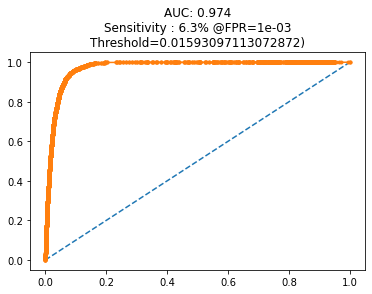

In [19]:
X_train,Y_train = train_dataset()
probs,yprob = compute_probs(network,X_train,Y_train)
fpr, tpr, thresholds,auc = compute_metrics(probs,yprob)
draw_roc(fpr, tpr,thresholds)

In [20]:
def test_dataset():
    X = np.zeros((200,220,220,3))
    Y = np.zeros((200))
    count = 0
    i = 0
    for person in os.listdir('./person_test'):
        
        for img in os.listdir('./person_test/'+str(person)+'/'):
            j = 0
            image = cv2.imread('./person_test/'+str(person)+'/'+str(img))
            X[count,:,:,:] = cv2.resize(image, (220,220), interpolation = cv2.INTER_AREA)
            Y[count] = i
            count += 1
        i += 1
    return X, Y

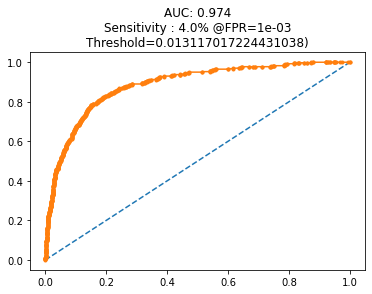

In [21]:
X_test,Y_test = test_dataset()
probs_test,yprob_test = compute_probs(network,X_test,Y_test)
fpr_test, tpr_test, thresholds_test,auc_test = compute_metrics(probs_test,yprob_test)
draw_roc(fpr_test, tpr_test,thresholds_test)

In [28]:
def compute_interdist(network):
    '''
    Computes sum of distances between all classes embeddings on our reference test image: 
        d(0,1) + d(0,2) + ... + d(0,9) + d(1,2) + d(1,3) + ... d(8,9)
        A good model should have a large distance between all theses embeddings
        
    Returns:
        array of shape (nb_classes,nb_classes) 
    '''
    res = np.zeros((40,40))
    
    ref_images = np.zeros((40,220,220,3))
    
    #generates embeddings for reference images
    for i in range(40):
        ref_images[i,:,:,:] = X_test[i*5,:,:,:]
    ref_embeddings = network.predict(ref_images)
    
    for i in range(40):
        for j in range(40):
            res[i,j] = compute_dist(ref_embeddings[i],ref_embeddings[j])
    return res
def draw_interdist(network,n_iteration):
    interdist = compute_interdist(network)
    
    data = []
    for i in range(40):
        data.append(np.delete(interdist[i,:],[i]))

    fig, ax = pyplot.subplots()
    ax.set_title('Evaluating embeddings distance from each other after {0} iterations'.format(3750))
    ax.set_ylim([0,3])
    pyplot.xlabel('Classes')
    pyplot.ylabel('Distance')
    ax.boxplot(data,showfliers=False,showbox=True)
    locs, labels = pyplot.xticks()
    pyplot.xticks(locs,np.arange(40))

    pyplot.show()

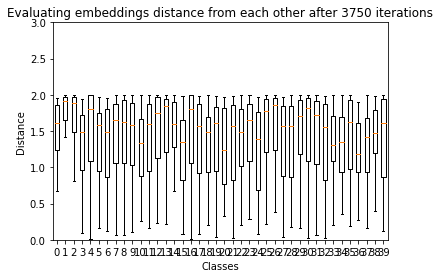

In [29]:
draw_interdist(network,3750)

In [16]:
def testing(img):
    img_ref = cv2.imread('./3.jpg')
    img_ref = cv2.resize(img_ref, (220,220), interpolation = cv2.INTER_AREA)
    img_test = cv2.resize(img, (220,220), interpolation = cv2.INTER_AREA)
    img_ref = np.expand_dims(img_ref, axis=0)
    img_test = np.expand_dims(img_test, axis=0)
    ref = loaded_model.predict(img_ref)
    test = loaded_model.predict(img_test)
    dist = compute_dist(ref,test)
    print(dist)
    if(dist<0.7):
        print("Same person")
    else:
        print("Different person")

In [19]:
testing(cv2.imread('./0.jpg'))

0.76216745
Different person
